In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import seaborn as sns

In [2]:
results_dir = Path("/home/alexander/projects/car_data_analysis/results")
results= dict()
results["test"] = results_dir.glob("*_test.csv")
results["train"] = results_dir.glob("*_train.csv")
results["runtimes"] = results_dir.glob("*_runtimes.csv")

for key in results:
    tmp = pd.DataFrame()
    for file in results[key]:
        method = file.stem.split("_")[0]
        method_results = pd.read_csv(file, )
        method_results["method"] = method
        tmp = pd.concat((tmp, method_results))
    results[key] = tmp

In [3]:
print(len(results["test"]))
results["test"].head()

1933343


,id,price,prediction,test,exp,method
0,146-94,2999,4456.6494,1,0,NN
1,81-29,7495,8161.6000,1,0,NN
2,125-354,3595,4126.2007,1,0,NN
3,157-193,8990,8028.7944,1,0,NN
4,64-262,1000,1290.2727,1,0,NN


In [4]:
results["train"].head()

,id,price,prediction,test,exp,method
0,0-1,750,1702.338113,0,0,LM
1,0-2,395,535.822121,0,0,LM
2,0-3,500,2115.681910,0,0,LM
3,0-4,800,462.805883,0,0,LM
4,0-5,800,526.931845,0,0,LM


In [5]:
results["runtimes"].head()

,seconds,method
0,3,GLM
1,3,GLM
2,3,GLM
3,6,GLM
4,3,GLM


,seconds
method,
CNN,21653.0
GLM,4.0
LM,3.0
NLP,817.0
NN,41.0
RF,93.0


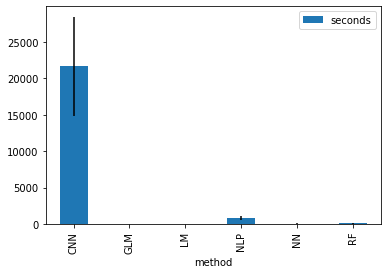

In [6]:
x = results["runtimes"].groupby("method")
x.mean().plot.bar(yerr=x.std())
plt.savefig("runtimes.png")
x.mean().round()
# TODO: add nice labels

## Metrics by method on test set

In [22]:
grouped = results["test"].groupby(["method","exp"])

def _r_sq(y_true, y_pred):
    SST = sum((y_true-y_true.mean())**2)
    SSR = sum((y_true-y_pred)**2)
    return (1 - SSR/SST)

def _mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_pred)

def _mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_pred)
    

mse = grouped.apply(lambda x: _mse(x["price"], x["prediction"]) )
mae = grouped.apply(lambda x: _mae(x["price"], x["prediction"]) )
rsq = grouped.apply(lambda x: _r_sq(x["price"], x["prediction"]) )
print(mse, mae, rsq)

method  exp
CNN     0      7.374508e+06
        1      7.358153e+06
        2      7.287705e+06
        3      7.340277e+06
        4      7.046280e+06
                   ...     
RF      26     1.427726e+06
        27     1.468232e+06
        28     1.501166e+06
        29     1.480048e+06
        30     1.438515e+06
Length: 185, dtype: float64 method  exp
CNN     0      2242.707561
        1      2230.767950
        2      2225.317991
        3      2264.075022
        4      2207.031923
                  ...     
RF      26      895.886689
        27      907.934184
        28      915.138712
        29      908.558333
        30      903.688799
Length: 185, dtype: float64 method  exp
CNN     0      0.074289
        1      0.078138
        2      0.082725
        3      0.096104
        4      0.120587
                 ...   
RF      26     0.821410
        27     0.816059
        28     0.813439
        29     0.814959
        30     0.819057
Length: 185, dtype: float64


In [23]:
metrics = {
    'mse' : {'mean':mse.mean(level="method"), 'std':mse.std(level="method")},
    'mae' : {'mean':mae.mean(level="method"), 'std':mae.std(level="method")},
    'rsq' : {'mean':rsq.mean(level="method"), 'std':rsq.std(level="method")},
}
metrics['mse']

{'mean': method
 CNN    7.305871e+06
 GLM    2.151657e+06
 LM     2.423889e+06
 NLP    2.311170e+06
 NN     1.819951e+06
 RF     1.472954e+06
 dtype: float64,
 'std': method
 CNN    186010.908756
 GLM     53725.253001
 LM      86095.991099
 NLP     51586.436998
 NN      59149.913074
 RF      27085.093648
 dtype: float64}

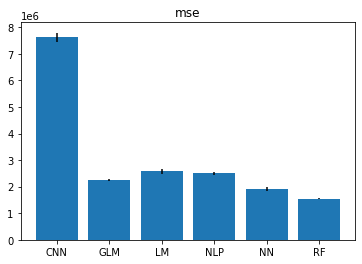

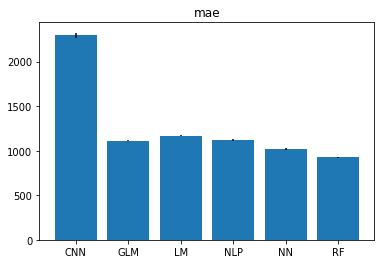

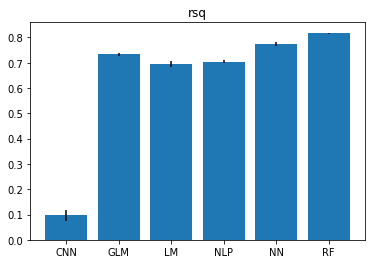

In [10]:
for metric, vals in metrics.items():
    plt.figure()
    plt.title(metric)
    plt.bar(vals['mean'].keys(), vals['mean'].to_list(), yerr=vals['std'].to_list())
    plt.savefig(f"{metric}_comparison.png")


## Pairwise performance in test set

In [14]:
results["test"] = results["test"][results["test"]["price"]<11000]
pred_by_ad = results["test"].groupby(["method", "id"]).agg({
    "price":"mean",
    "prediction":"mean",
    "exp":"count"
})
#NOTE: average test prediction
pred_by_ad

price   prediction  exp
method id                            
CNN    0-0      800  6169.397947   17
       0-1      750  4368.787230   10
       0-10     795  5940.931009   11
       0-100    850  5633.011478    9
       0-101    799  4991.345427   11
...             ...          ...  ...
RF     99-93   6450  6542.499181   12
       99-94   6495  6385.244307    9
       99-95   6600  5038.450985    8
       99-98   6100  8132.293260   12
       99-99   6995  7611.449654    8

[205710 rows x 3 columns]

In [15]:
def plot(truth, preds, title):   
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
    ax[0,0].hist2d(truth, preds, bins=50)
    ax[0,0].plot(truth, truth, color="white", label="Ideal")
    ax[0,0].legend()
    ax[0,0].set_xlabel("Truth")
    ax[0,0].set_ylabel("Prediction")
    ax[0,0].set_title("Confusion density")

    ax[0,1].scatter(truth, preds, color="red", alpha=0.2)
    ax[0,1].plot(truth, truth, color="black", label="Ideal")
    ax[0,1].legend()
    ax[0,1].set_xlabel("Truth")
    ax[0,1].set_title("Confusion scatter")
    
    _, bins, _ = ax[1,0].hist(truth, bins=50, alpha=0.4, label="Truth")
    ax[1,0].hist(preds, bins=bins, alpha=0.4, label="Pred")
    ax[1,0].legend()
    ax[1,0].set_xlabel("Price")
    ax[1,0].set_ylabel("Freq")
    ax[1,0].set_title("Price distribution")
    
    ax[1,1].hist(truth-preds, bins=50, alpha=0.4)
    ax[1,1].set_xlabel("Residual")
    ax[1,1].set_title("Residual distribution")

    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(f"{title}.png")
    

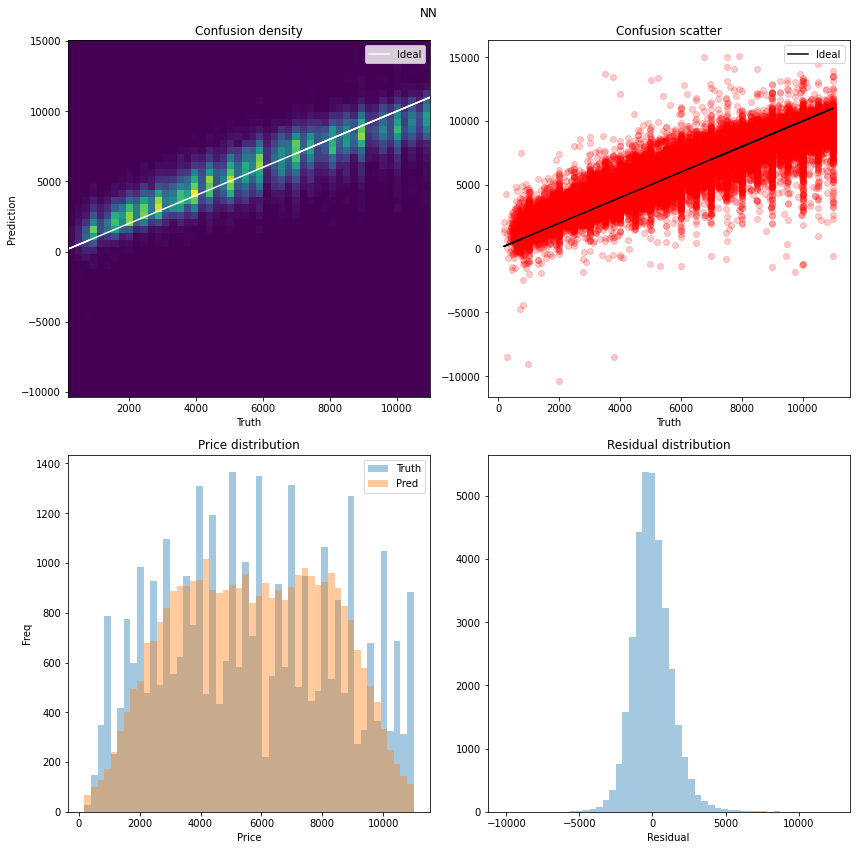

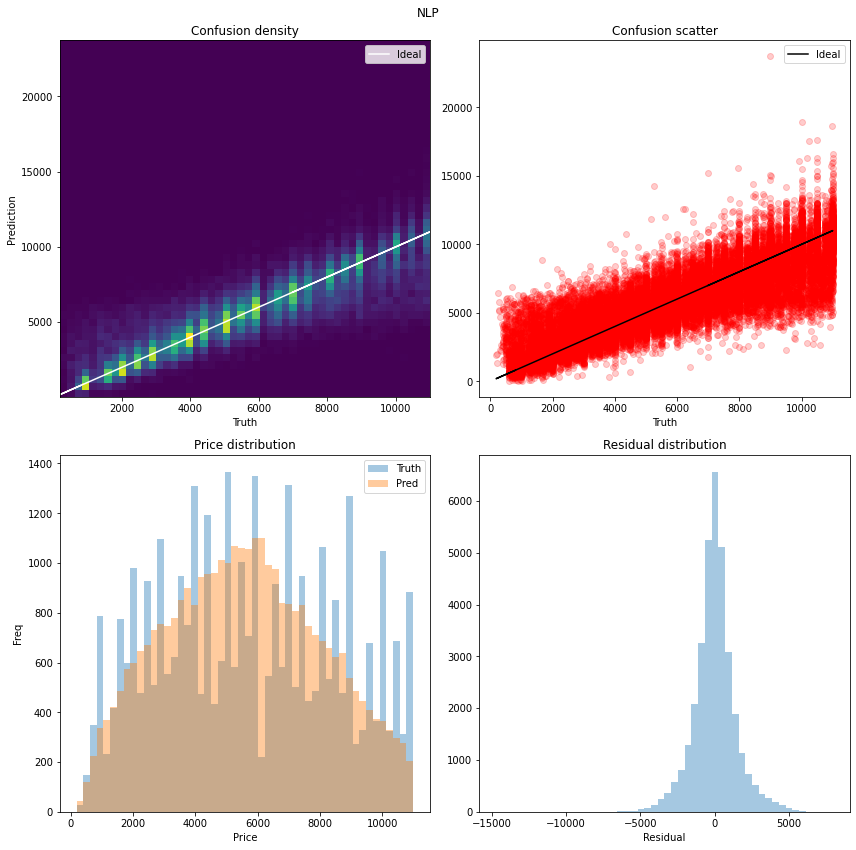

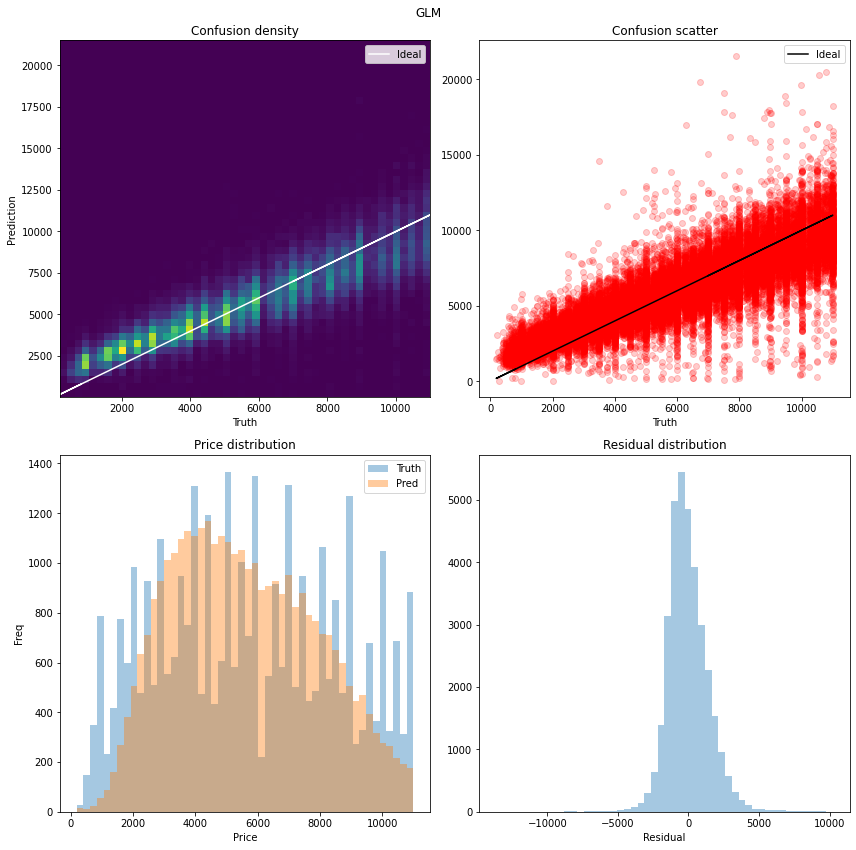

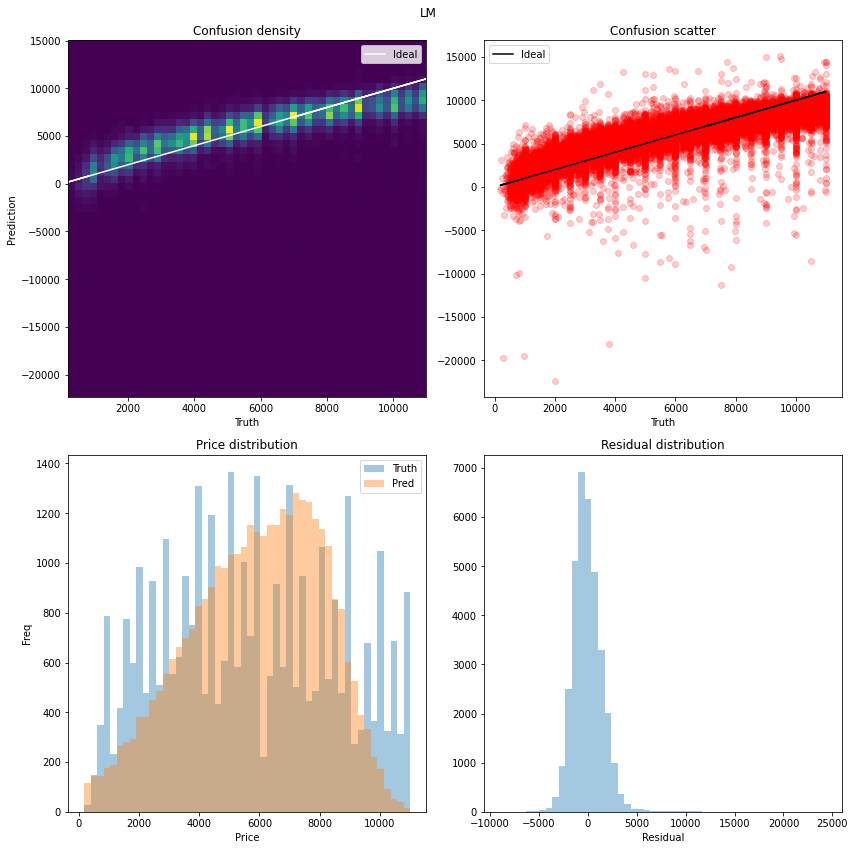

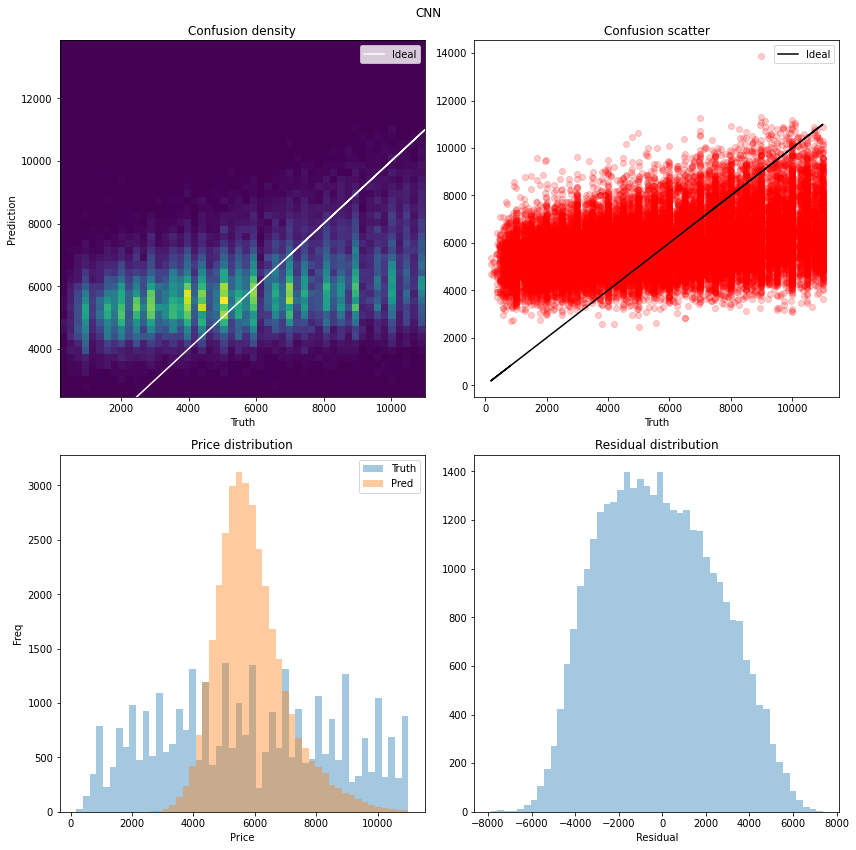

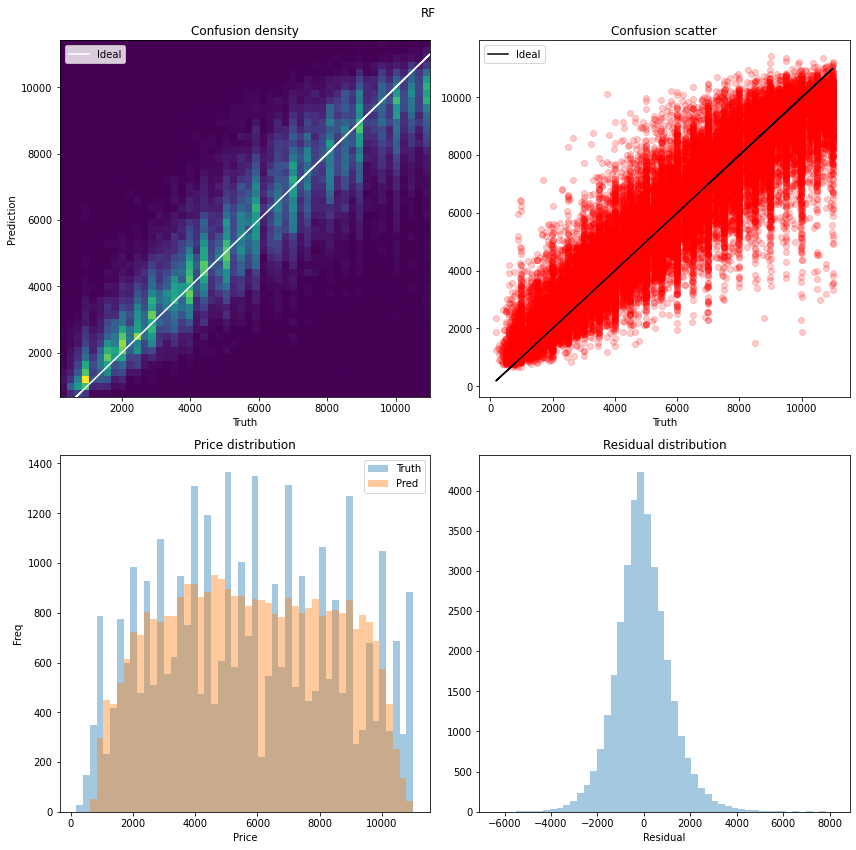

In [16]:
for method in set(pred_by_ad.index.get_level_values("method")):
    plot(pred_by_ad.loc[method]["price"], pred_by_ad.loc[method]["prediction"], method)